# Analysing rental store data

## Storing data into dictionary of dfs

In [36]:
import duckdb

dfs= {}

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()
    for name in description["name"]:
        if name[0] != '_':
            dfs[name] = conn.sql(f"FROM staging.{name};").df()

            duckdb.register(name, dfs[name])

## Task 1 - EDA in python

a) Which movies are longer then 3 hours (180 minutes), title and length

In [37]:
duckdb.sql("""--sql
           SELECT title, length
           FROM film
           WHERE length >= 180
           ORDER BY length
""").df().head()

,title,length
0,ALLEY EVOLUTION,180
1,CONFIDENTIAL INTERVIEW,180
2,SOMETHING DUCK,180
3,NASH CHOCOLAT,180
4,IMPACT ALADDIN,180


b) Which movies have the workd "love" in its title? showing following columns
- title
- rating
- length 
- description

In [38]:
## I used chatgpt after I wrote one \ first and didn't realize I need two in order for it to escape correctly
duckdb.sql("""--sql
        SELECT
           title,
           rating,
           length,
           description
        FROM film
        WHERE
           regexp_matches(title, '\\bLOVE\\b')
""").df()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


d) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie. The Manager wants to know the 10 most expensive movies to rent per day.


In [39]:
duckdb.sql("""--sql
        SELECT
           title,
           rental_rate,
           rental_duration,
           rental_rate / rental_duration as cost_per_day
        FROM film
        ORDER BY cost_per_day DESC;
""").df().head(62)

,title,rental_rate,rental_duration,cost_per_day
0,PATHS CONTROL,4.99,3,1.663333
1,BACKLASH UNDEFEATED,4.99,3,1.663333
2,BEHAVIOR RUNAWAY,4.99,3,1.663333
3,VIRTUAL SPOILERS,4.99,3,1.663333
4,TEEN APOLLO,4.99,3,1.663333
...,...,...,...,...
57,PARK CITIZEN,4.99,3,1.663333
58,SUIT WALLS,4.99,3,1.663333
59,BEAST HUNCHBACK,4.99,3,1.663333
60,SUNRISE LEAGUE,4.99,3,1.663333


NOTE: There are 62 movies that all cost the same to rent per day

e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have
played in.


In [40]:
films_joined = duckdb.sql("""--sql
    SELECT 
        a.first_name || ' ' || a.last_name AS actor,
        a.actor_id::INT as actor_id,
        f.title,
        f.description,
        f.rating,
        f.release_year,
        f.rental_duration,
        f.length,
        c.name AS category
    FROM film f
        LEFT JOIN film_actor fa ON f.film_id = fa.film_id
        LEFT JOIN actor a ON a.actor_id = fa.actor_id
        LEFT JOIN film_category fc ON fc.film_id = f.film_id
        LEFT JOIN category c ON fc.category_id = c.category_id
""")

duckdb.sql("""--sql
    SELECT 
        actor,
        COUNT(*) AS number_films
    FROM films_joined
    GROUP BY actor
    ORDER BY number_films DESC
""").df().head(10)



,actor,number_films
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,UMA WOOD,35
8,HENRY BERRY,35
9,VAL BOLGER,35


f) Now it's time for you to choose your own question to explore the sakila database! Write down 3-5
questions you want to answer and then answer them using pandas and duckdb.


1. Which film categories have the highest average movie rating (MPAA rating), and how does the average film length differ across categories?

In [41]:
duckdb.sql("""--sql
    SELECT
        c.name AS category,
        AVG(CASE
           WHEN f.rating = 'G' THEN 1
           WHEN f.rating = 'PG' THEN 2
           WHEN f.rating = 'PG-13' THEN 3
           WHEN f.rating = 'R' THEN 4
           WHEN f.rating = 'NC-17' THEN 5
           END) AS avg_rating,
           ROUND(AVG(f.length)) AS avg_length
    FROM film f
    LEFT JOIN film_category fc ON f.film_id = fc.film_id
    LEFT JOIN category c ON fc.category_id = c.category_id
    GROUP BY category
    ORDER BY avg_rating DESC""").df()

,category,avg_rating,avg_length
0,Music,3.725490,114.0
1,Games,3.327869,128.0
2,New,3.190476,111.0
3,Sports,3.162162,128.0
4,Family,3.086957,115.0
5,Drama,3.080645,121.0
6,Sci-Fi,3.049180,108.0
7,Animation,3.015152,111.0
8,Classics,3.000000,112.0
9,Foreign,2.986301,122.0


2. Which are the top 5 films that has been rented out the most?

In [42]:
duckdb.sql("""--sql
    SELECT
        f.title,
        COUNT(*) AS number_rental
    FROM film f
    LEFT JOIN inventory i ON f.film_id = i.film_id
    LEFT JOIN rental r on i.inventory_id = r.inventory_id
    GROUP BY f.title
    ORDER BY number_rental DESC
""").df().head()

,title,number_rental
0,BUCKET BROTHERHOOD,34
1,ROCKETEER MOTHER,33
2,JUGGLER HARDLY,32
3,RIDGEMONT SUBMARINE,32
4,FORWARD TEMPLE,32


3. For each actor, what is the average length of the films they appear in, and which actor appears in the longest films on average?

In [43]:
duckdb.sql("""--sql
    SELECT 
    a.first_name || ' ' || a.last_name as actor,
    AVG(f.length) AS avg_length
    FROM actor a
    LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id
    LEFT JOIN film f ON fa.film_id = f.film_id
    GROUP BY actor
    ORDER BY avg_length DESC""").df().head()

,actor,avg_length
0,JUDY DEAN,137.733333
1,FAY WOOD,133.818182
2,FRED COSTNER,131.555556
3,DARYL WAHLBERG,130.935484
4,MATTHEW JOHANSSON,130.850000


## Task 2 - graphs

a) Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them
with special offers. Create a bar chart showing the top 5 customers by total spend.


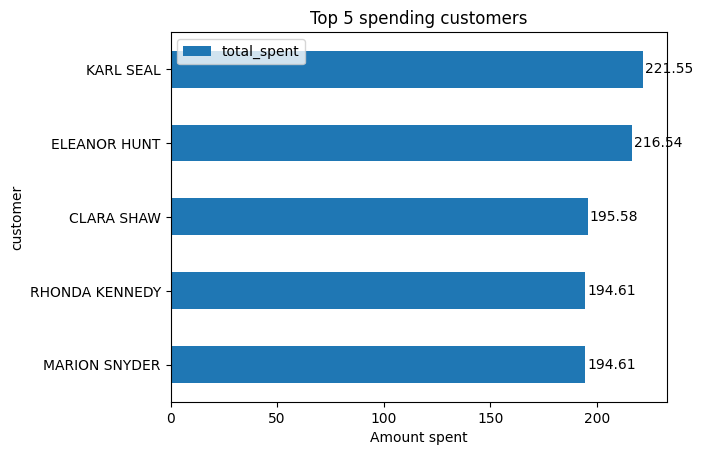

In [47]:
top_cumstomers = duckdb.sql("""--sql
    SELECT
        c.first_name || ' ' || c.last_name AS customer,
        SUM(p.amount) AS total_spent
    FROM customer c
    LEFT JOIN payment p ON c.customer_id = p.customer_id
    GROUP BY customer
    ORDER BY total_spent DESC""").df()

ax = top_cumstomers.head(5).plot(kind="barh", x="customer", y="total_spent", title="Top 5 spending customers", xlabel="Amount spent")
ax.invert_yaxis()

for bar in ax.patches:
    value = bar.get_width()
    ax.text(
        value + 1,
        bar.get_y() + bar.get_height()/2,
        f"{value:.2f}",
        va = "center"
    )

b) How much money does each film category bring in? Make a bar chart showing total revenue per film
category.
